<a href="https://colab.research.google.com/github/fzanart/Socialz/blob/wip/mu_lambda_ES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scipy --upgrade

In [2]:
import random
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import qmc
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive/')
import time

Mounted at /content/drive/


In [3]:
df = pd.read_pickle('/content/drive/MyDrive/Socialz/dataset.pkl')
df = df[['Degree Centrality', 'anomaly_ratio']]
df

,Degree Centrality,anomaly_ratio
0,0.044489,0.138978
1,0.031855,0.062857
2,0.017876,0.141230
3,0.017876,0.105587
4,0.017742,0.062500
...,...,...
4113,0.000403,0.000000
4114,0.000403,0.000000
4115,0.000403,0.000000
4116,0.000403,0.000000


mu: The number of parents selected each iteration.

lambda: Size of the population.

lambda / mu: Number of children generated from each selected parent.

In [5]:
def objective(candidate):
  return qmc.discrepancy(candidate, method='L2-star',workers=-1)

In [6]:
objective(df)

0.6922122692776922

In [7]:
# check if a point is within the bounds of the search
def in_bounds(point):
	# assuming all dimensions should lie in the same range, e.i. [0,1]
	test = ((point > 0) == (point < 1)).all()
	# Returns True if they are within the bounds, false otherwise.
	return test

In [25]:
# evolution strategy (mu, lambda) algorithm
def es_comma(initial_record, objective, n_iter, step_size, mu, lam):
  best, best_eval = None, 1e+10
	# calculate the number of children per parent
  n_children = int(lam / mu)
	
  # initial population
  population = list()
  
  for i in range(lam):
    candidate = df.copy()
    sample = candidate.sample(lam, random_state=1)
    candidate.loc[sample.index] = np.random.rand(sample.shape[0],sample.shape[1])
    population.append(candidate)

  # perform the search
  for epoch in range(n_iter):
    # evaluate the fitness for the population
    scores = [objective(candidate) for candidate in population]
    # rank scores in ascending order
    ranks = np.argsort(np.argsort(scores))
    # select the indexes for the top mu ranked solutions, drop the worse results	
    selected = [i for i,_ in enumerate(ranks) if ranks[i] < mu]
    # create offspring from parents
    offspring = list()
    for i in selected:
      # check if this parent is the best solution ever seen
      if scores[i] < best_eval:
        best, best_eval = population[i], scores[i]
        print('%d, Best eval: = %.5f' % (epoch, best_eval))

        # create offspring for parent
        for j in range(n_children):
          print("\t", j, end =" ")
          aux = None
          timeout = time.time() + 10 # seconds to find a solution within the bounds
          while aux is None or not in_bounds(aux.to_numpy()):
            aux = population[i].loc[sample.index]
            aux = aux + np.random.rand(sample.shape[0],sample.shape[1]) * np.random.choice([-1,1]) * step_size
            if time.time() > timeout:
              aux = population[i].loc[sample.index]
              print('timeout')
              break
          population[i].loc[sample.index] = aux
          child = population[i]
          offspring.append(child)

    # replace population with children
    population = offspring

  return [best, best_eval]

In the es_plus version, offspring and the parents comprise the population at the end instead of just the offspring as the es_comma version. 

In [26]:
# evolution strategy (mu, lambda) algorithm
def es_plus(initial_record, objective, n_iter, step_size, mu, lam):
  best, best_eval = None, 1e+10
	# calculate the number of children per parent
  n_children = int(lam / mu)
	
  # initial population
  population = list()
  
  for i in range(lam):
    candidate = df.copy()
    sample = candidate.sample(lam, random_state=1)
    candidate.loc[sample.index] = np.random.rand(sample.shape[0],sample.shape[1])
    population.append(candidate)

  # perform the search
  for epoch in range(n_iter):
    # evaluate the fitness for the population
    scores = [objective(candidate) for candidate in population]
    # rank scores in ascending order
    ranks = np.argsort(np.argsort(scores))
    # select the indexes for the top mu ranked solutions, drop the worse results	
    selected = [i for i,_ in enumerate(ranks) if ranks[i] < mu]
    # create offspring from parents
    offspring = list()
    for i in selected:
      # check if this parent is the best solution ever seen
      if scores[i] < best_eval:
        best, best_eval = population[i], scores[i]
        print('%d, Best eval: = %.5f' % (epoch, best_eval))
        
        # keep the parent
        offspring.append(population[i])

        # create offspring for parent
        for j in range(n_children):
          print("\t", j, end =" ")
          aux = None
          timeout = time.time() + 10 # seconds to find a solution within the bounds
          while aux is None or not in_bounds(aux.to_numpy()):
            aux = population[i].loc[sample.index]
            aux = aux + np.random.rand(sample.shape[0],sample.shape[1]) * np.random.choice([-1,1]) * step_size
            if time.time() > timeout:
              aux = population[i].loc[sample.index]
              print('timeout')
              break
          population[i].loc[sample.index] = aux
          child = population[i]
          offspring.append(child)

    # replace population with children
    population = offspring

  return [best, best_eval]

In [27]:
# define the total iterations
n_iter = 5000
# define the maximum step size
step_size = 0.10
# number of parents selected
mu = 1235
# the number of children generated by parents
lam = 1236
# perform the evolution strategy (mu, lambda) search
best, score = es_plus(df, objective, n_iter, step_size, mu, lam)

0, Best eval: = 0.48410
	 0 timeout
0, Best eval: = 0.48348
	 0 timeout
0, Best eval: = 0.48291
	 0 timeout
0, Best eval: = 0.48251
	 0 timeout
0, Best eval: = 0.48250
	 0 timeout
0, Best eval: = 0.48229
	 0 timeout
0, Best eval: = 0.48076
	 0 timeout
0, Best eval: = 0.48006
	 0 timeout
0, Best eval: = 0.47959
	 0 timeout


In [28]:
score

0.47958762299909186

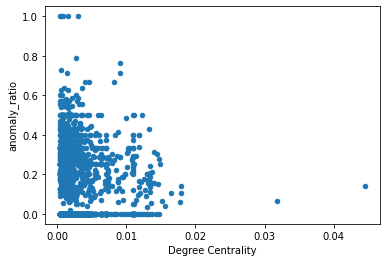

In [29]:
df.plot.scatter(x='Degree Centrality', y='anomaly_ratio')

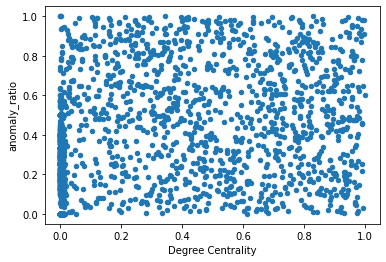

In [30]:
best.plot.scatter(x='Degree Centrality', y='anomaly_ratio')

In [31]:
df.count().sum() - (df == best).astype(int).sum().sum()

2472

In [32]:
2472/(df.shape[0]*df.shape[1])

0.30014570179698885

In [33]:
best, score = es_comma(df, objective, n_iter, step_size, mu, lam)

0, Best eval: = 0.48596
	 0 timeout
0, Best eval: = 0.48569
	 0 timeout
0, Best eval: = 0.48545
	 0 timeout
0, Best eval: = 0.48455
	 0 timeout
0, Best eval: = 0.48286
	 0 timeout
0, Best eval: = 0.48228
	 0 timeout
0, Best eval: = 0.48105
	 0 timeout
0, Best eval: = 0.48078
	 0 timeout
0, Best eval: = 0.47983
	 0 timeout
0, Best eval: = 0.47972
	 0 timeout


In [34]:
score

0.4797185452781695

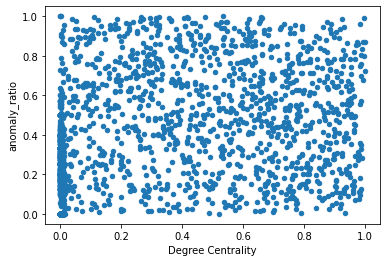

In [35]:
best.plot.scatter(x='Degree Centrality', y='anomaly_ratio')